### Image Processing with Python

Now that you have downloaded some Planetscope imagery, what can you do with it? This workshop includes an interactive overview of basic image processing with rasters and vectors in Python with spatial libraries like rasterio and geopandas.


#### Background
Lake Lagunita on Stanford Campus is not a permanantly filled lake unless high rainfall fills it by diversion from San Francisquito Creek. Let's use Python libraries to inspect this area and the timing of a flooding event in the winter of 2022/2023 ([link to Explorer](https://www.planet.com/explorer/?s=VQxuExgIQwOCE3LaspaYgQ)) with Planetscope imagery.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import spatial and plotting libraries

Below we will import a handful of raster and vector processing libraries.  Notable processing libraries include **rasterio** and **geopandas**.

**Rasterio** is a Python library for working with geospatial raster data. Rasterio makes it easy to open, read, and write raster datasets in various formats, such as GeoTIFF and JPEG, and perform common geospatial operations.

**GeoPandas** is an open-source Python library that extends the capabilities of the popular Pandas library to handle geospatial data. Many geopandas datasets will take the form of a dataframe with a "geometry" column that allows for spatial operations like plotting, joining, or clipping and aggregating raster data. It simplifies the manipulation and analysis of geographic datasets, allowing users to work with both vector and raster data within a unified framework.

#### Install Libraries

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 46.7 MB/s eta 0:00:00


#### Import Libraries

In [ ]:
# Import libraries
import os
import glob


import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio import features
from skimage import exposure

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/"
glob.glob(os.path.join(data_dir, "*"))

['/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/geoms',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data']

In [ ]:
glob.glob(os.path.join(data_dir, "data", "*composite.tif"))

['/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-02-15_strip_6290924_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-07-30_strip_6682704_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-12-18_strip_6153179_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-08-30_strip_6743722_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-04-24_strip_6458341_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-08-16_strip_6717370_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-03-25_strip_6384901_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-11-15_strip_6080437_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-11-26_strip_6104067_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 20

In [ ]:
files = glob.glob(os.path.join(data_dir, "data", "*composite.tif"))

Let's select a single file to explore its contents. We'll revisit the rest later.

In [ ]:
test_file = os.path.join(data_dir, "data", "2023-04-15_strip_6437085_composite.tif")
os.path.exists(test_file)

True

In [ ]:
# Read the file with Rasterio
with rasterio.open(test_file) as src:
    print(src.meta)
    # From the open src image, let's save the array as a variable.
    arr = src.read()/10000

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 438, 'height': 343, 'count': 8, 'crs': CRS.from_epsg(32610), 'transform': Affine(3.0, 0.0, 572298.0,
       0.0, -3.0, 4142520.0)}


In [ ]:
arr.shape

(8, 343, 438)

As we read the array, we must divide reflectance by 10,000 because Planet imagery stores reflectance as a value scaled by 10,000 to adhere to the required data type (uint16) while maintaining decimal precision (described in Atmospheric Corrections on page 18 of the [Product Spec](https://assets.planet.com/docs/Planet_PSScene_Imagery_Product_Spec_letter_screen.pdf)).

### Plotting individual bands in greyscale

Next, we will plot individual bands in greyscale to check absorption features of the land cover types we do know.

In [ ]:
# Order of the bands for 8-band planetscope imagery is from lowest to highest wavelength
band_order = ["coastal_blue", "blue", "green_I", "green", "yellow", "red", "red_edge", "nir"]

In [ ]:
# With the list above, we can identify the index of a color by name and use it to access that layer in the array.
band_order.index("red")

5

In [ ]:
arr[5].shape

(343, 438)

We'll use the ordered list of bands to loop over and plot each band in greyscale, and title the plot according to the color name.

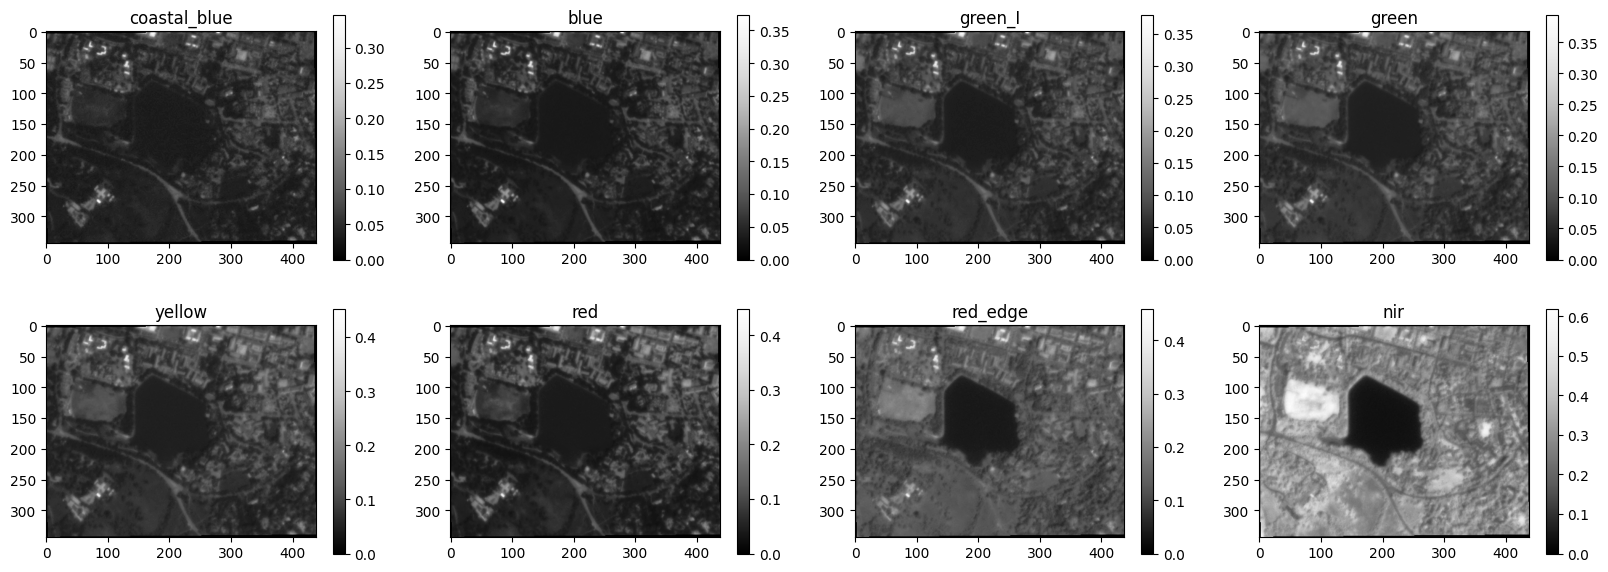

In [ ]:
# Define the layout of our figure
nrow = 2
ncol = 4
f, axes = plt.subplots(nrow, ncol, figsize=(5*ncol, 3.5*nrow))

# Loop over every band name and axis available in the plot together
for band_name, ax in zip(band_order, axes.flatten()):
    # Extract the band from our array
    band_index = band_order.index(band_name)
    band_arr = arr[band_index]

    # Plot in greyscale to the subplot
    im = ax.imshow(band_arr, cmap="Greys_r")
    f.colorbar(im, ax=ax)

    # Set the title for the subplot
    ax.set_title(band_name)

We've plotted all of the bands!

Note reflectance and absorption of different wavelengths by features we know:
- water absorbing most wavelengths more than other features
- buildings reflecting most wavelengths, so they're bright in most subplots
- grassy field absorb blues and reds, and in increasing intensity reflect yellow, greens, red edge, and NIR

### Creating a function to plot an RGB

Let's plot an RGB image next!

First, we can test how best to stretch and plot the image before writing a function.

In [ ]:
# Save R, G, and B as variables
red = arr[band_order.index("red")]
green = arr[band_order.index("green")]
blue = arr[band_order.index("blue")]

# Stack them into a single array
img = np.stack([red, green, blue], axis=2)

When plotting an RGB image you are plotting 3 bands together and decisions must be made about how best to balance the color contrast. This is unlike individual bands plotted above where matplotlib can dynamically stretch to fit the range of individual bands.

One common approach to color balancing an RGB is rescaling all bands to a range defined by their 2nd and 98th percentiles.

In [ ]:
# Rescale surface reflectance values for plotting with color balance
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

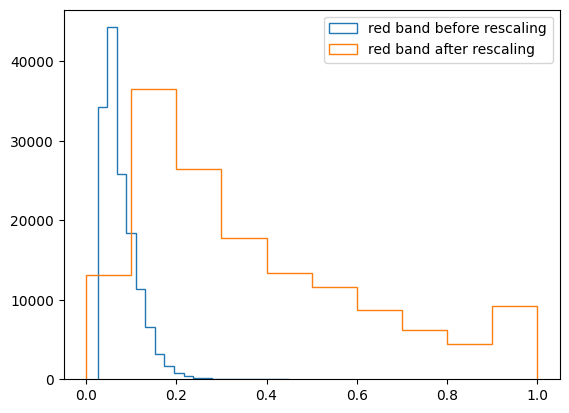

In [ ]:
f, ax = plt.subplots()
ax.hist(red[red!=0], label="red band before rescaling", histtype="step", bins = 20);
ax.hist(img_rescale[:, :, 0][red!=0], label="red band after rescaling", histtype="step")
ax.legend();

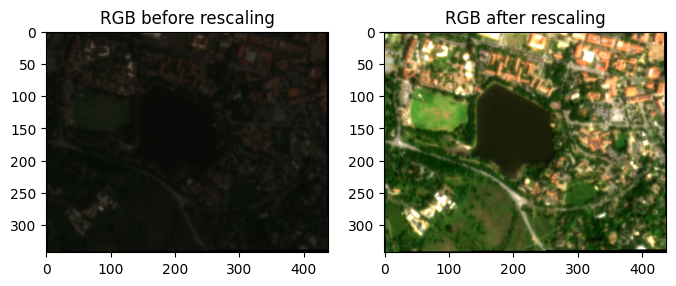

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img)
axes[0].set_title("RGB before rescaling")
axes[1].imshow(img_rescale)
axes[1].set_title("RGB after rescaling");

We can define a function, and even play with different band orders:

In [ ]:
def arr_to_rgb(arr, use_bands=["red", "green", "blue"]):
    band_order = [
        "coastal_blue", "blue", "green_I", "green",
        "yellow", "red", "red_edge", "nir"
    ]
    b1 = arr[band_order.index(use_bands[0])]
    b2 = arr[band_order.index(use_bands[1])]
    b3 = arr[band_order.index(use_bands[2])]

    img = np.stack([b1, b2, b3], axis=2)

    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

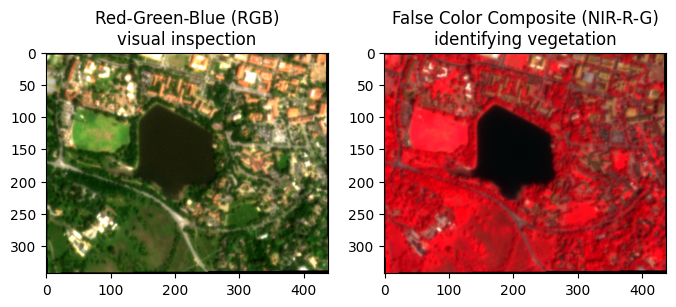

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(arr_to_rgb(arr))
axes[0].set_title("Red-Green-Blue (RGB)\nvisual inspection")
axes[1].imshow(arr_to_rgb(arr,  use_bands=["nir", "red", "green"]))
axes[1].set_title("False Color Composite (NIR-R-G)\nidentifying vegetation");

Let's turn these steps into a function, and loop over every image to get a better view of when water began to flood Lake Lagunita.

### Plotting several RGB images

First, we'll sort our files in alphabetical order.  This will allow us to iterate over the list in an order that is chronological.

In [ ]:
# These are out of order
files

['/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-02-15_strip_6290924_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-07-30_strip_6682704_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-12-18_strip_6153179_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-08-30_strip_6743722_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-04-24_strip_6458341_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-08-16_strip_6717370_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-03-25_strip_6384901_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-11-15_strip_6080437_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-11-26_strip_6104067_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 20

In [ ]:
# These are now in alphabetical order
files.sort()
files

['/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-11-15_strip_6080437_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-11-15_strip_6080597_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-11-26_strip_6104067_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-12-02_strip_6117199_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-12-18_strip_6153179_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-01-17_strip_6219068_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-01-30_strip_6250675_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-02-15_strip_6290924_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-03-02_strip_6325499_composite.tif',
 '/content/drive/MyDrive/Colab Data/GIS Day 20

In [ ]:
# We can decide on how many rows and columns would display a total of 24 images
len(files)

24

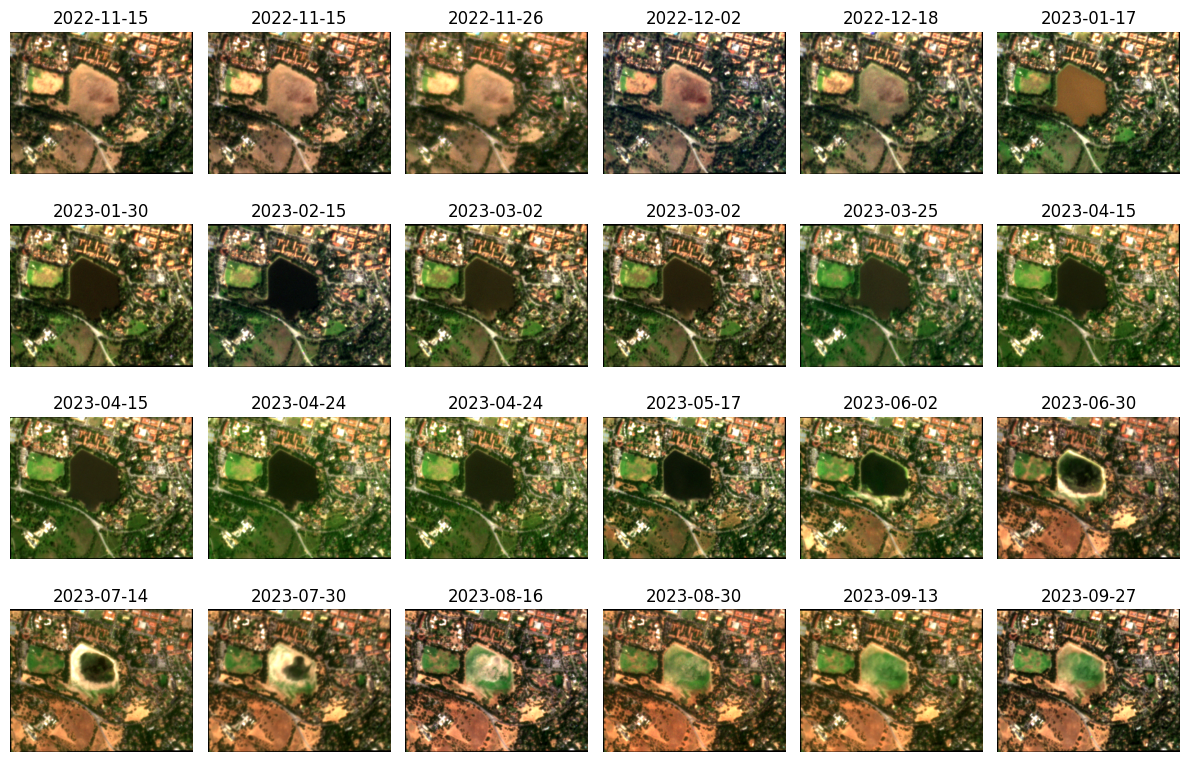

In [ ]:
nrow = 4
ncol = 6

f, axes = plt.subplots(nrow, ncol, figsize=(2*ncol, 2*nrow))
for file, ax in zip(files, axes.flatten()):
    with rasterio.open(file) as src:
        arr = src.read()/10000
    rgb_im = arr_to_rgb(arr)
    #rgb_im = arr_to_rgb(arr,  use_bands=["nir", "red", "green"])
    ax.imshow(rgb_im)

    date = os.path.basename(file).split("_")[0]
    ax.set_title(date)

for ax in axes.flatten():
    ax.axis("off")
plt.tight_layout()

We can visually assess these images and guess that flooding began at the end of December.

### Raster Analysis with Band Math: Calculating an Index

Next, we'll calculate a spectral index.  Spectral indices are mathematical algorithms used in remote sensing to highlight specific features or characteristics of the Earth's surface.

The Normalized Difference Water Index (NDWI) is derived from the Near-Infrared (NIR) and Green (G) channels. This formula is used to detect water bodies:

NDWI = (G-NIR)/(G+NIR)

Higher NDWI values typically indicate the presence of water, while lower values correspond to land surfaces.  The NDWI values correspond to the following ranges:

| Range      | Description                  |
|------------|------------------------------|
| 0.2 – 1   | Water surface      |
| 0.0 – 0.2   | Flooding, humidity      |
| -0.3 – 0.0    | Moderate drought, non-aqueous surfaces      |
| -1 – -0.3    | Drought, non-aqueous surfaces      |

In [ ]:
# Read the test file in with rasterio, and pull Green and NIR
with rasterio.open(test_file) as src:
    arr = src.read()/10000
green = arr[band_order.index("green")]
nir = arr[band_order.index("nir")]

In [ ]:
ndwi = (green - nir)/(green + nir)

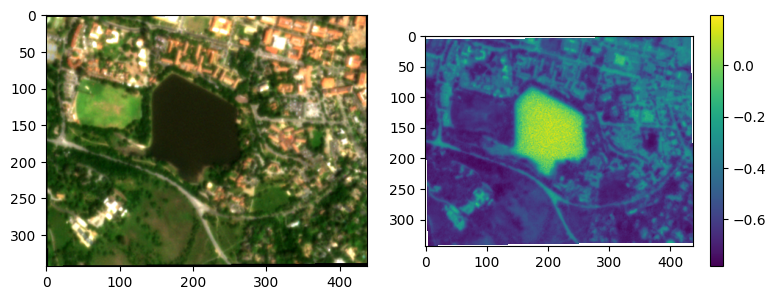

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(8, 3))

# plot the RGB in the first subplot
rgb = arr_to_rgb(arr)
axes[0].imshow(rgb)

# Plot NDWI in the second subplot, high values will indicate the presence of water.
im = axes[1].imshow(ndwi)
f.colorbar(im, ax=axes[1])

plt.tight_layout();

Spectral indices like NDWI help us to objectively declare an area we're looking at is likely "water"

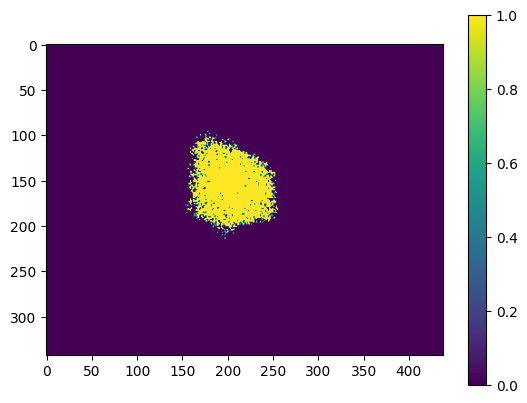

In [ ]:
f, ax = plt.subplots()
im = plt.imshow(ndwi > 0)
f.colorbar(im, ax=ax)

### Vector Data: How does NDWI look inside of our Lake Lagunita Boundary?

Next, we'll read a vector dataset containing boundaries around Lake Lagunita.

In this section, we will load a geojson into a geodataframe.

In [ ]:
# boundaries which surround the lake
geojson_filename = os.path.join(data_dir, 'geoms', 'lake-lagunita.geojson')
gdf = gpd.read_file(geojson_filename)
gdf

geometry
0  POLYGON ((-122.17712 37.42450, -122.17800 37.4...

A geodataframe is like a pandas dataframe, but contains a standardized spatial attribute called "geometry" which can be used to map a vector dataset spatially or to extract data from spatial geotiffs.

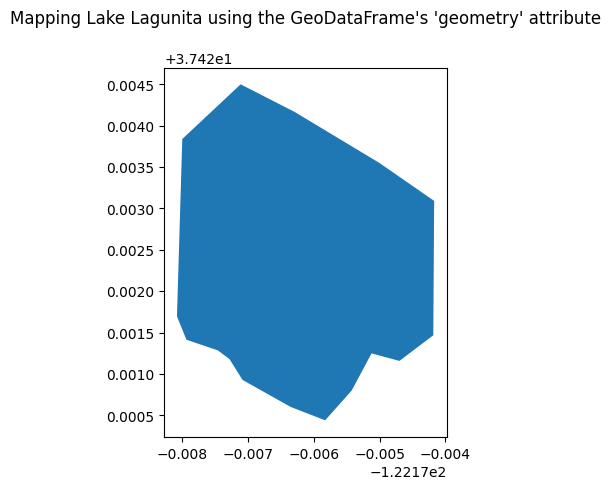

In [ ]:
gdf.plot()
plt.title("Mapping Lake Lagunita using the GeoDataFrame's 'geometry' attribute\n");

### Masking raster data with vector data
To join these two, we can create an array out of our vector dataset that is True where Lake Lagunita is present.

Converting the vector dataset to a raster requires using the CRS and Tranform of the source raster.

In [ ]:
with rasterio.open(test_file) as src:
    # reading metadata
    metadata = src.meta

# Cast to the same CRS as the rasterio image
gdf_crs = gdf.to_crs(metadata["crs"])

# Create an array with a geometry mask
aoi_mask = features.geometry_mask(gdf_crs.geometry, ndwi.shape, metadata["transform"])
# Flipping the mask so that True values are over the field
lake_mask = ~aoi_mask

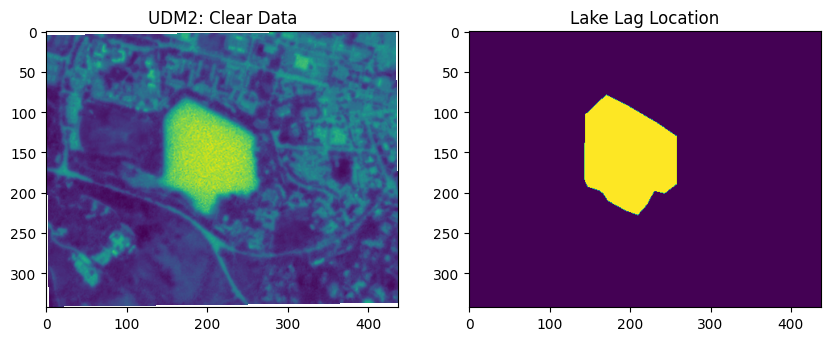

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(ndwi)
axes[0].set_title("UDM2: Clear Data")
axes[1].imshow(lake_mask)
axes[1].set_title("Lake Lag Location");

Yellow are Trues in the right image.

Below, we can use the lake_mask to mask values in the NDWI array

In [ ]:
# all NDWI values in the lake
ndwi[lake_mask]

array([-0.59990242, -0.60466849, -0.58866684, ..., -0.49433249,
       -0.52315914, -0.52229498])

The median of the masked values will be the median for the lake in the NDWI array.

In [ ]:
median_ndwi_in_lake = ndwi[lake_mask].mean()
print(f"The median NDWI in measured in the lake is {median_ndwi_in_lake}")

The median NDWI in measured in the lake is -0.043109648565362306


In [ ]:
median_ndwi_in_lake = ndwi[~np.isnan(ndwi) * ~lake_mask].mean()
print(f"The median NDWI in measured outside of the lake is {median_ndwi_in_lake}")

The median NDWI in measured outside of the lake is -0.5508857888236413


### Calculating a timeseries with an area of interest

Next, we'll scale up this workflow to run over every image and plot a timeseries of NDWI in Lake Lagunita.

In [ ]:
def calc_ndwi(image_filepath):
    """
    Wrapper to calculate NDWI for an image
    """
    with rasterio.open(image_filepath) as src:
        arr = src.read()/10000
    green = arr[band_order.index("green")]
    nir = arr[band_order.index("nir")]
    ndwi = (green - nir)/(green + nir)

    return ndwi

def median_ndwi_in_aoi(image_filepath, geojson_filepath):
    """
    Wrapper to report median NDWI within a geojson geometry for an input image.
    """

    ndwi = calc_ndwi(image_filepath)
    with rasterio.open(image_filepath) as src:
        metadata = src.meta

    # Create an array with True values over the field location
    gdf = gpd.read_file(geojson_filepath)
    aoi_mask = features.geometry_mask(
            gdf.to_crs(metadata["crs"]).geometry, ndwi.shape, metadata["transform"])

    median_ndwi_in_lake = ndwi[lake_mask].mean()

    return median_ndwi_in_lake

Below, we'll create empty lists for `dates` and `medians` which we'll fill with values as we loop through each file.

In [ ]:
dates = []
medians = []
for im_filepath in files:
    # From the filename, we'll pull dates.
    filename = os.path.basename(im_filepath)
    date = filename.split("_")[0]
    print(f"Original filename: {im_filepath}")
    print(f"Date: {date}")
    dates.append(date)

    # Calculate medians
    median = median_ndwi_in_aoi(im_filepath, geojson_filename)
    medians.append(median)

Original filename: /content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-11-15_strip_6080437_composite.tif
Date: 2022-11-15
Original filename: /content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-11-15_strip_6080597_composite.tif
Date: 2022-11-15
Original filename: /content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-11-26_strip_6104067_composite.tif
Date: 2022-11-26
Original filename: /content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-12-02_strip_6117199_composite.tif
Date: 2022-12-02
Original filename: /content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2022-12-18_strip_6153179_composite.tif
Date: 2022-12-18
Original filename: /content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-01-17_strip_6219068_composite.tif
Date: 2023-01-17
Original filename: /content/drive/MyDrive/Colab Data/GIS Day 2023/Workshop 2/data/2023-01-30_strip_6250675_composite.tif
Date: 2023-01-30
Original filename: /content/drive/

Next, we can plot all dates and values as a scatterplot.

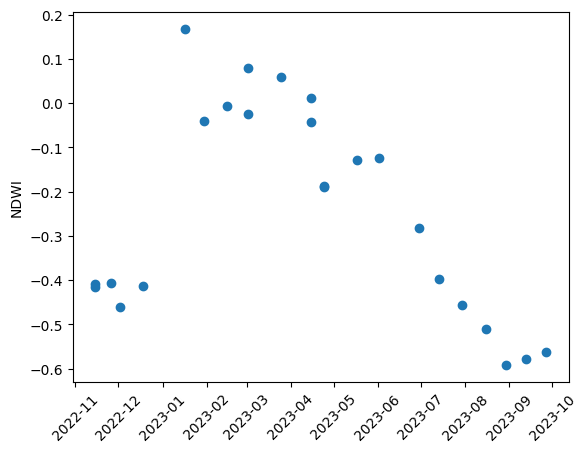

In [ ]:
f, ax = plt.subplots()

ax.scatter(pd.to_datetime(dates), medians)
for label in ax.get_xticklabels():
    label.set_rotation(45)
ax.set_ylabel("NDWI");

From this plot, we can guess that Lake Lagunita began flooding in mid-December.

Congratulations! You've finished the Processing with Python workshop.